Device set to use cuda:0


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

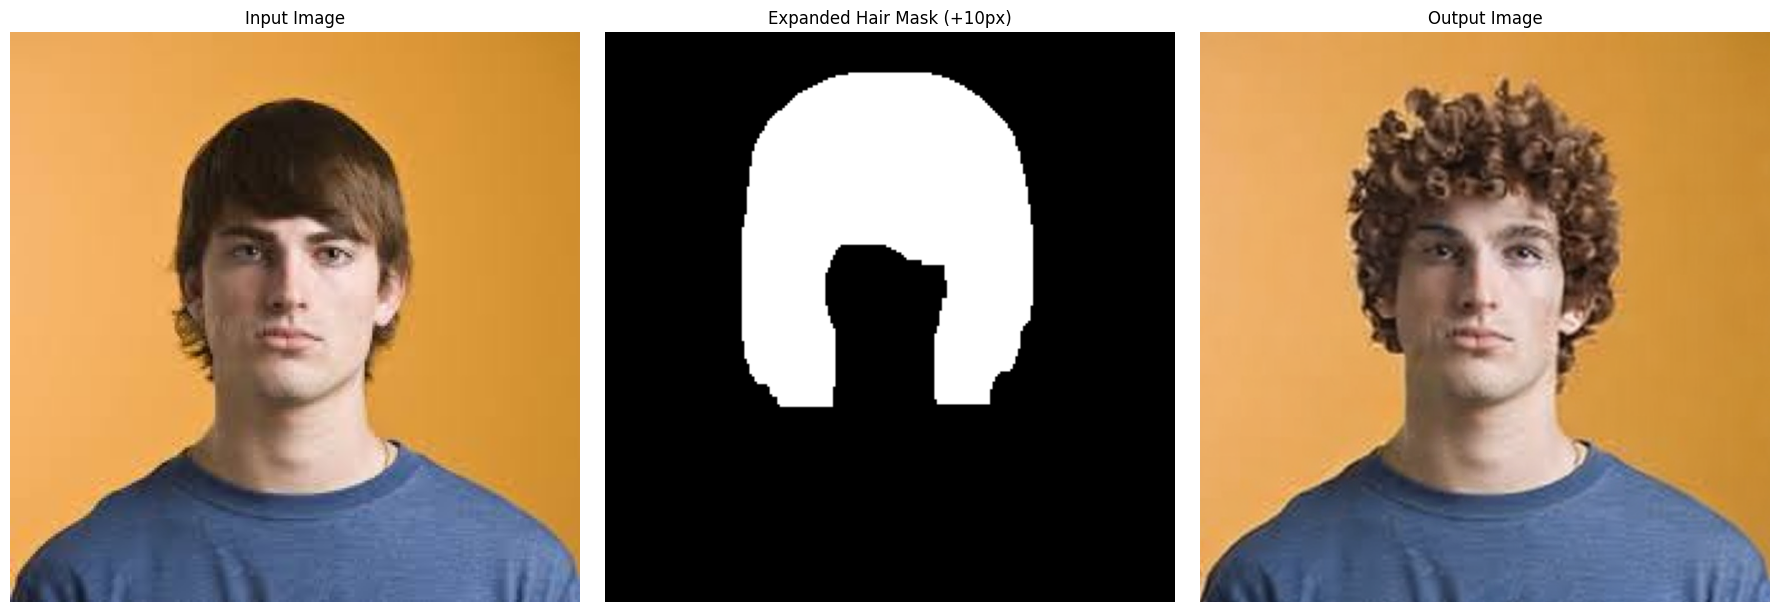

In [19]:
from transformers import pipeline
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2  # For mask dilation

# 1. Load Models
segmentation_model = pipeline("image-segmentation", model="jonathandinu/face-parsing")

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting", torch_dtype=torch.float16
)

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe.to(device)

# 2. Image Input
image = Image.open("headshot11.jpg").convert("RGB")

# 3. Hair Segmentation
segmentation_results = segmentation_model(image)
hair_mask = None
for result in segmentation_results:
    if result["label"].lower() == "hair":
        hair_mask = result["mask"]
        break

if hair_mask is None:
    raise ValueError("Hair segmentation not found in the image.")

# Convert hair_mask to a NumPy array if it's a PIL Image
if isinstance(hair_mask, Image.Image):
    hair_mask = np.array(hair_mask)

# Ensure binary format
hair_mask = (hair_mask > 0).astype(np.uint8)

# 4. Expand Mask by X pixels (dilate)
X = 10  # <-- You can change this to any number of pixels to expand
kernel = np.ones((2 * X + 1, 2 * X + 1), np.uint8)
dilated_mask = cv2.dilate(hair_mask, kernel, iterations=1)

# Convert to PIL Image for inpainting
mask_image = Image.fromarray((dilated_mask * 255).astype(np.uint8)).resize(image.size)

# 5. Stable Diffusion Inpainting
prompt = "fluffy brown curly hair"
result_image = pipe(
    prompt=prompt,
    image=image,
    mask_image=mask_image
).images[0]

result_image.save("headshot11_result.png")

# 6. Display Input, Mask and Output Images using matplotlib
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(image)
axs[0].set_title("Input Image")
axs[0].axis("off")

axs[1].imshow(mask_image, cmap="gray")
axs[1].set_title(f"Expanded Hair Mask (+{X}px)")
axs[1].axis("off")

axs[2].imshow(result_image)
axs[2].set_title("Output Image")
axs[2].axis("off")

plt.tight_layout()
plt.show()

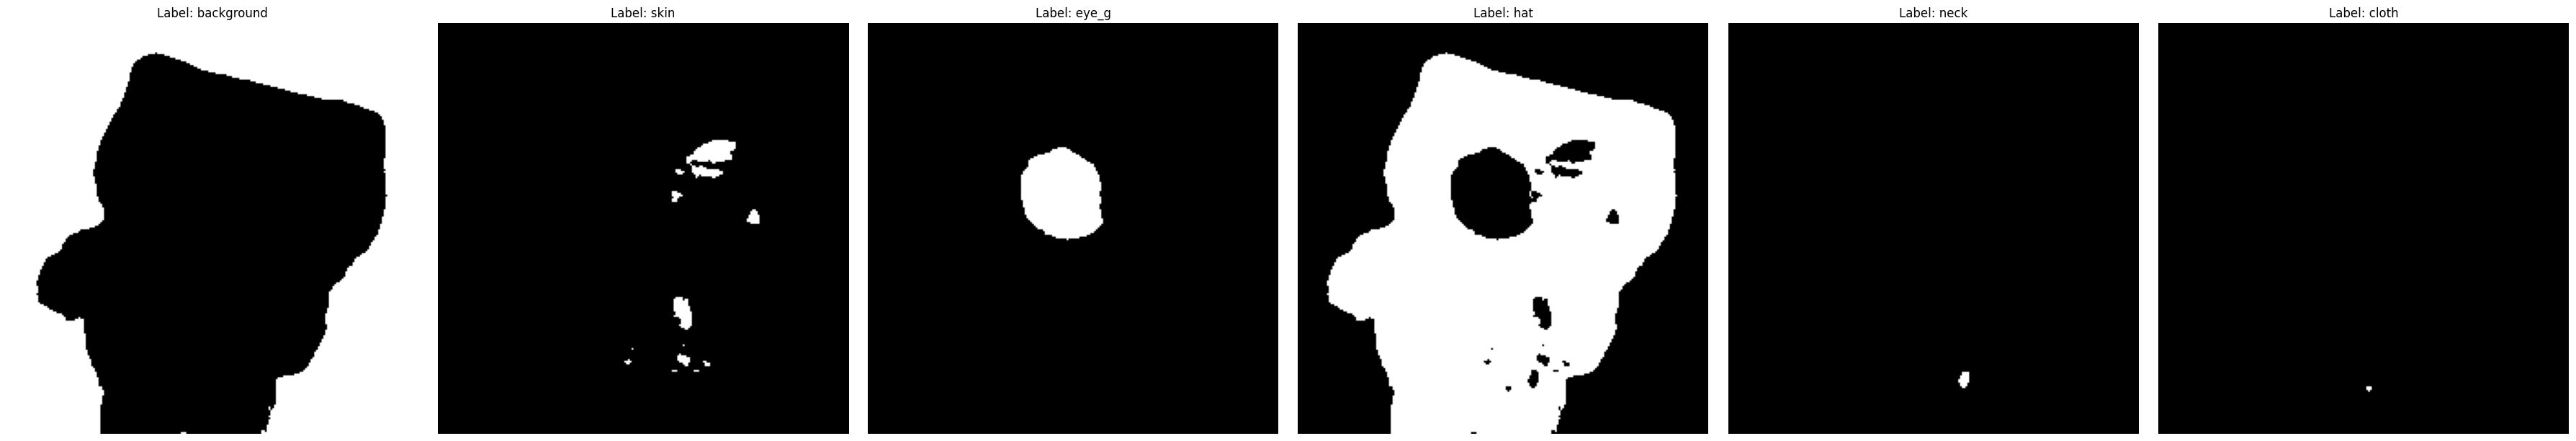

In [7]:
# 3. Hair Segmentation (and other masks)
segmentation_results = segmentation_model(image)

# Plot all masks
num_masks = len(segmentation_results)
fig, axs = plt.subplots(1, num_masks, figsize=(6 * num_masks, 6))

if num_masks == 1:
    axs = [axs]  # Ensure it's iterable

for i, result in enumerate(segmentation_results):
    mask = result["mask"]
    label = result["label"]

    # Convert to NumPy if needed
    if isinstance(mask, Image.Image):
        mask = np.array(mask)

    axs[i].imshow(mask, cmap="gray")
    axs[i].set_title(f"Label: {label}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
# 1. Load Models
segmentation_model = pipeline("image-segmentation", model="jonathandinu/face-parsing") # https://huggingface.co/jonathandinu/face-parsing
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint") #you can also use controlnet_v11p_sd15_seg
inpaint_pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16
).to("cuda")

Device set to use cpu


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# 2. Image Input
image = Image.open("input_image.jpg").convert("RGB")

# 3. Hair Segmentation
segmentation_results = segmentation_model(image)
hair_mask = None
for result in segmentation_results:
    if result["label"] == "hair":
        hair_mask = result["mask"]
        break

In [ ]:
# 4. Mask Refinement (Optional)
# ... (Code to refine hair_mask if needed) ...

In [ ]:
# 5. Prepare ControlNet Input
mask_image = Image.fromarray((hair_mask * 255).astype(np.uint8))
mask_image = mask_image.resize((512,512)) #resize to match stable diffusion size

# Create the inverse mask for inpainting
inverse_mask = Image.fromarray((1-hair_mask) * 255).convert("L").resize((512,512))

image = image.resize((512,512))

In [ ]:
# 6. Stable Diffusion Inpainting
prompt = "A fade haircut, detailed, realistic" # or "mullet hairstyle"
negative_prompt = "blurry, unrealistic, bad quality"

generated_image = inpaint_pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=image,
    mask_image=inverse_mask,
    controlnet_conditioning_image=mask_image,
    controlnet_conditioning_scale=0.8,
).images[0]

In [ ]:
# 7. Image Output
generated_image.save("output_image.jpg")
display(generated_image)

In [20]:
!pip install -U diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.32.2
    Uninstalling diffusers-0.32.2:
      Successfully uninstalled diffusers-0.32.2


In [1]:
import torch
from diffusers import StableDiffusion3Pipeline

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-large", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")

image = pipe(
    "A capybara holding a sign that reads Hello World",
    num_inference_steps=28,
    guidance_scale=3.5,
).images[0]
image.save("capybara.png")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GatedRepoError: 401 Client Error. (Request ID: Root=1-680983cd-7e09d55453a17d0d4efa280e;c49a7dab-a302-4f8d-a8da-a24ad75fef14)

Cannot access gated repo for url https://huggingface.co/stabilityai/stable-diffusion-3.5-large/resolve/main/model_index.json.
Access to model stabilityai/stable-diffusion-3.5-large is restricted. You must have access to it and be authenticated to access it. Please log in.